In [1]:
import importlib

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch as th
import torch_geometric as pyg

import LPGNN

2022-08-29 17:21:43.650236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 17:21:43.650270: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [25]:
importlib.reload(LPGNN.popularity_similarity)

<module 'LPGNN.popularity_similarity' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/popularity_similarity.py'>

In [2]:
def gromov(G, node_i, node_j, node_k, node_l):
    node_tuple = np.random.choice(G.nodes(), 4, replace=False)
    try:
        d01 = nx.shortest_path_length(G, source=node_tuple[0], target=node_tuple[1], weight=None)
        d23 = nx.shortest_path_length(G, source=node_tuple[2], target=node_tuple[3], weight=None)
        d02 = nx.shortest_path_length(G, source=node_tuple[0], target=node_tuple[2], weight=None)
        d13 = nx.shortest_path_length(G, source=node_tuple[1], target=node_tuple[3], weight=None)
        d03 = nx.shortest_path_length(G, source=node_tuple[0], target=node_tuple[3], weight=None)
        d12 = nx.shortest_path_length(G, source=node_tuple[1], target=node_tuple[2], weight=None)

        s = [d01 + d23, d02 + d13, d03 + d12]
        s.sort()
        return (s[-1] - s[-2]) / 2
    except Exception as e:
        print('No shortest path')
        return None

def sample_hyperbolicity(G, num_samples=50000):
    hyps = []
    for i in range(num_samples):
        node_tuple = np.random.choice(G.nodes(), 4, replace=False)
        hyps.append(gromov(G, *node_tuple))

    return np.max(hyps), np.mean(hyps)

In [88]:
PS = LPGNN.popularity_similarity.generatePSNetwork(N=200, avg_k=4, gamma=2.7, T=0.5, seed=10)

In [89]:
PS_Labne = LPGNN.labne.generateLaBNE(PS)

torch.Size([200])
Calculating best minimal value for power law fit


(<Figure size 720x720 with 1 Axes>, <PolarAxesSubplot:>)

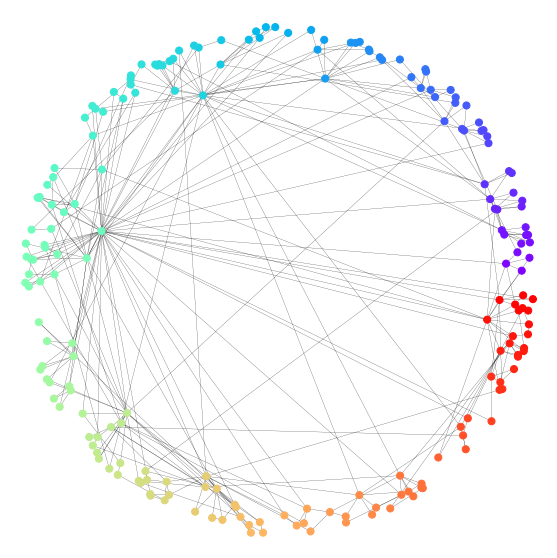

In [90]:
LPGNN.popularity_similarity.drawPSNetwork(PS, polar_projection=True, with_labels=False, figsize=(10,10))

(<Figure size 720x720 with 1 Axes>, <PolarAxesSubplot:>)

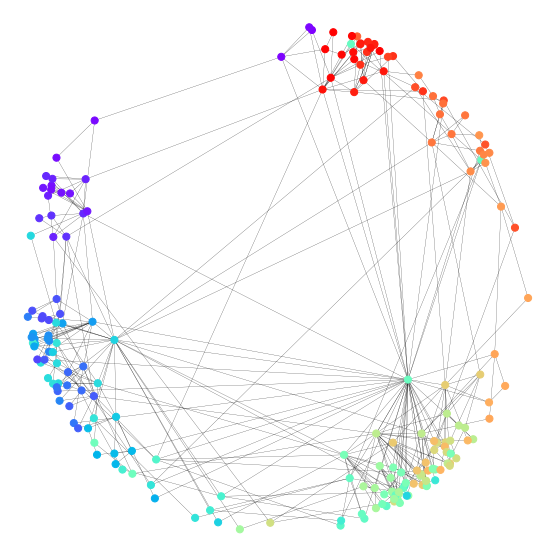

In [91]:
LPGNN.popularity_similarity.drawPSNetwork(PS_Labne, polar_projection=True, with_labels=False, figsize=(10,10), pos_name='LaBNE_node_polar_positions')

In [47]:
nx.average_shortest_path_length(nx.Graph(pyg.utils.to_networkx(PS)))

5.251658291457287

In [70]:
sum(np.arange(len(edges)) / np.sum(np.arange(len(edges))))

1.0

In [71]:
def random_edge_remove(data:pyg.data.Data, total_remove=100, max_iter=100000):
    G = pyg.utils.to_networkx(data)
    G = nx.Graph(G)
    t = 0
    t_c = 0
    while t < total_remove and t_c < max_iter:
        edges = list(G.edges())
        random_edge = np.random.choice(len(edges), 1, p=np.arange(len(edges)) / np.sum(np.arange(len(edges))))[0]
        edge = edges[random_edge]
        G.remove_edge(*edge)
        if not nx.is_connected(G):
            G.add_edge(*edge)
        else:
            try:
                shortest_path_length = nx.shortest_path_length(G, source=edge[0], target=edge[1], weight=None)
                if shortest_path_length <= 2:
                    G.add_edge(*edge)
                else:
                    t += 1
                    #print('Removed edge {}'.format(edge), 'length now {}'.format(shortest_path_length))
            except:
                G.add_edge(*edge)
        t_c += 1

    return G.edges()

In [95]:
new_edges = random_edge_remove(PS, total_remove=30, max_iter=1000)
PS.edge_index = th.Tensor(np.array(new_edges).T).type(th.int64)
PS.edge_index = pyg.utils.to_undirected(PS.edge_index)
PS.edge_index.shape

torch.Size([2, 574])

In [96]:
PS_PrunedLabne = LPGNN.labne.generateLaBNE(PS)

torch.Size([200])
Calculating best minimal value for power law fit


In [98]:
PS_PrunedLabne.edge_index = PS.edge_index

(<Figure size 720x720 with 1 Axes>, <PolarAxesSubplot:>)

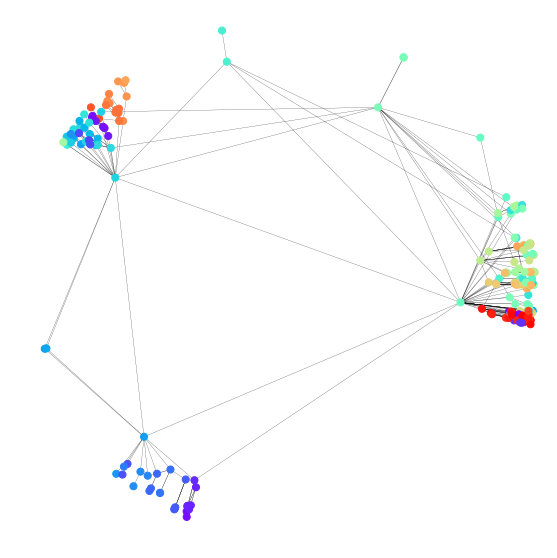

In [99]:
LPGNN.popularity_similarity.drawPSNetwork(PS_PrunedLabne, polar_projection=True, with_labels=False, figsize=(10,10), pos_name='LaBNE_node_polar_positions')

In [100]:
ASI = th.Tensor(np.loadtxt('Network_Files/ASI_t0.txt')).T.type(th.int64)
ASI = ASI-1
ASI = pyg.utils.to_undirected(ASI)
ASI = pyg.data.Data(edge_index=ASI)
#ASI = pyg.utils.remove_isolated_nodes(ASI)[0]
ASI_nx = pyg.utils.to_networkx(ASI)

/home/mf/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/torch_geometric/data/storage.py:259: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [102]:
new_edges = random_edge_remove(ASI, total_remove=3000, max_iter=1000)
ASI.edge_index = th.Tensor(np.array(new_edges).T).type(th.int64)
ASI.edge_index = pyg.utils.to_undirected(ASI.edge_index)
ASI.edge_index.shape

torch.Size([2, 118704])

In [103]:
ASI_nx = pyg.utils.to_networkx(ASI)
nx.average_shortest_path_length(ASI_nx)

/home/mf/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/torch_geometric/data/storage.py:259: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


3.527343567015746

In [186]:
PGP = th.Tensor(np.loadtxt('Network_Files/PGP_t0.txt')).T.type(th.int64)
PGP = PGP-1
PGP = pyg.utils.to_undirected(PGP)
PGP = pyg.data.Data(edge_index=PGP)
#PGP = pyg.utils.remove_isolated_nodes(PGP)[0]
PGP_nx = pyg.utils.to_networkx(PGP)
PGP_nx = nx.Graph(nx.to_undirected(PGP_nx))

/home/mf/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/torch_geometric/data/storage.py:259: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [193]:
while 1:
    edges = nx.bidirectional_shortest_path(PGP_nx, 0, 2000)
    if len(edges) > 20:
        print(edges)
        break
    PGP_nx.remove_edge(edges[5], edges[6])
nx.is_connected(PGP_nx)

NetworkXNoPath: No path between 0 and 2000.

In [194]:
nx.is_connected(PGP_nx)

False

In [131]:
nx.bidirectional_shortest_path(ASI_nx, 6000, 12001)

[6000, 10, 2, 12001]

In [68]:
PS_nx = pyg.utils.to_networkx(PS)

In [71]:
nx.bidirectional_shortest_path(PS_nx, 187, 1260)

[187, 30, 3, 13, 1260]

In [73]:
nx.astar_path(PS_nx, 187, 1260)

[187, 30, 3, 13, 1260]

In [72]:
sht_paths = list(nx.all_pairs_shortest_path(PS_nx))

In [65]:
for path in sht_paths:
    print(path[0])
    for key, value in path[1].items():
        print("    ", key, value)

0
     0 [0]
     1 [0, 1]
     2 [0, 2]
     3 [0, 3]
     5 [0, 5]
     8 [0, 8]
     11 [0, 11]
     15 [0, 15]
     17 [0, 17]
     19 [0, 19]
     20 [0, 20]
     22 [0, 22]
     25 [0, 25]
     31 [0, 31]
     35 [0, 35]
     36 [0, 36]
     38 [0, 38]
     42 [0, 42]
     49 [0, 49]
     52 [0, 52]
     56 [0, 56]
     57 [0, 57]
     75 [0, 75]
     114 [0, 114]
     116 [0, 116]
     118 [0, 118]
     123 [0, 123]
     124 [0, 124]
     129 [0, 129]
     130 [0, 130]
     132 [0, 132]
     134 [0, 134]
     146 [0, 146]
     149 [0, 149]
     153 [0, 153]
     154 [0, 154]
     167 [0, 167]
     184 [0, 184]
     185 [0, 185]
     197 [0, 197]
     4 [0, 1, 4]
     6 [0, 1, 6]
     10 [0, 1, 10]
     13 [0, 1, 13]
     37 [0, 1, 37]
     41 [0, 1, 41]
     73 [0, 1, 73]
     83 [0, 1, 83]
     95 [0, 1, 95]
     100 [0, 1, 100]
     103 [0, 1, 103]
     109 [0, 1, 109]
     131 [0, 1, 131]
     148 [0, 1, 148]
     163 [0, 1, 163]
     170 [0, 1, 170]
     196 [0, 1, 196]
    